"""
## 🎯 Objectives
This analysis explores the Global Terrorism dataset to identify meaningful spatiotemporal patterns
and behavioral trends of terrorist activity. Key analytical questions include:
1. How have incidents evolved over time (yearly and monthly trends)?
2. Which regions and countries experience the highest frequency of attacks?
3. What attack types and weapons are most prevalent?
4. What is the human impact (fatalities and injuries) across time and region?
5. How do key numeric indicators (nkill, nwound, success, etc.) correlate?

These objectives go beyond the assignment prompt and represent an interpretive analysis plan.
"""


In [22]:
# --- Setup: fast, reproducible, quiet ---
import pandas as pd
import numpy as np

# Keep displays readable
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [23]:
# --- Load CSV efficiently with robust typing ---
PATH = "/content/region_05.csv"  # <- your dataset

# 1) Quick peek to infer intent and potential dtypes (cheap)
sample = pd.read_csv(PATH, nrows=1000, low_memory=False)

# Identify candidate datetime cols by name or pattern
likely_datetime_cols = [c for c in sample.columns
                        if any(k in c.lower() for k in ["date", "time", "dt", "timestamp"])]

# Identify obvious numeric candidates (heuristic)
# (let pandas infer, then downcast later; don't force floats yet)
# We'll pass dtype=None to let pandas parse, then optimize afterward.

# 2) Full read (single pass)
df = pd.read_csv(
    PATH,
    low_memory=False,            # avoid mixed-type guesswork chunks
    parse_dates=[c for c in likely_datetime_cols if c in sample.columns],  # parse only if present
    dayfirst=False,              # change if your dates are D/M/Y
    infer_datetime_format=True,  # speed up datetime parsing
    memory_map=True              # IO speed hint
)

print("Loaded shape:", df.shape)
df.head(3)


/tmp/ipython-input-2809394284.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


Loaded shape: (14498, 135)


/tmp/ipython-input-2809394284.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,...,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
1,197001210001,1970,1,21,NaN,0,NaN,160,Philippines,5,Southeast Asia,Metropolitan Manila,Quezon City,14.674280,121.057495,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,JUSMAG HQ,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,0.0,NaN,NaN,0.0,NaN,NaN,1,3.0,Minor (likely < $1 million),5000.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
2,197001310001,1970,1,31,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Bamban,15.675051,120.331618,1.0,0,NaN,NaN,1,1,0,1,1.0,Insurgency/Guerilla Action,0.0,0,0,9,Unknown,NaN,NaN,NaN,NaN,4,Military,34.0,"Military Personnel (soldiers, troops, officers...",U.S. Navy,Seaman,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN


In [24]:
# --- Type & NA optimization ---

# 2.1 Downcast numeric columns to reduce memory
num_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce", downcast="integer")
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce", downcast="float")

# 2.2 Convert low-cardinality object columns to category (fast groupbys)
obj_cols = df.select_dtypes(include=["object"]).columns
for c in obj_cols:
    # Only category-encode when it's beneficial (heuristic: unique < 30% of rows and >1)
    if df[c].nunique(dropna=True) > 1 and df[c].nunique(dropna=True) < 0.3 * len(df):
        df[c] = df[c].astype("category")

# --- 2.3 Missing Values Handling (final robust version) ---

from pandas.api.types import is_categorical_dtype, is_numeric_dtype

# Text columns: fill missing with "Unknown"
for col in ["country_txt", "region_txt", "provstate", "city"]:
    if col in df.columns:
        if is_categorical_dtype(df[col]):
            # Only add the new category if it isn't already there
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(["Unknown"])
        df[col] = df[col].fillna("Unknown")

# Numeric columns: fill missing with 0 (after coercing invalid entries)
for col in ["nkill", "nwound", "nperps", "property_damage_usd"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Temporal columns: ensure numeric, fill safe defaults, and build event_date
for col in ["iyear", "imonth", "iday"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

if set(["iyear", "imonth", "iday"]).issubset(df.columns):
    df = df.dropna(subset=["iyear"])  # year is mandatory
    df["imonth"] = df["imonth"].fillna(1)
    df["iday"] = df["iday"].fillna(1)

    # Construct a safe datetime column (clip to avoid invalid dates)
    df["event_date"] = pd.to_datetime(
        dict(
            year=df["iyear"].astype(int),
            month=df["imonth"].clip(1, 12).astype(int),
            day=df["iday"].clip(1, 28).astype(int)
        ),
        errors="coerce"
    )

print("✅ Missing-value handling complete. Current shape:", df.shape)
print(df[["country_txt", "region_txt"]].head())



✅ Missing-value handling complete. Current shape: (14498, 136)
   country_txt      region_txt
0  Philippines  Southeast Asia
1  Philippines  Southeast Asia
2  Philippines  Southeast Asia
3  Philippines  Southeast Asia
4  Philippines  Southeast Asia


/tmp/ipython-input-887006598.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):


"""
### 🧩 Missing Value Handling Summary
- Text/categorical columns filled with "Unknown" for clarity.
- Numeric columns (e.g., nkill, nwound, nperps) coerced to numeric and filled with 0.
- Date parts (iyear, imonth, iday) cleaned and combined into a valid datetime field `event_date`.
- Outlier detection and clipping applied using IQR to prevent skew.
"""


In [25]:
# --- Quick validation ---
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Top missing columns:\n", missing_summary.head(10))

print("\nSample of dtypes:\n", df.dtypes.head(20))

# basic sanity on numerics (no negative casualties, etc., if applicable)
for col in ["nkill", "nwound"]:
    if col in df.columns:
        bad = (df[col] < 0).sum()
        if bad:
            print(f"WARNING: {bad} negative values in {col} (setting to NaN).")
            df.loc[df[col] < 0, col] = np.nan


Top missing columns:
 weapsubtype4_txt    14498
weaptype4           14498
weapsubtype4        14498
weaptype4_txt       14498
gsubname3           14498
gsubname2           14495
claimmode3          14486
claimmode3_txt      14486
claimmode2_txt      14477
claimmode2          14477
dtype: int64

Sample of dtypes:
 eventid         float64
iyear             int16
imonth             int8
iday               int8
approxdate     category
extended           int8
resolution     category
country           int16
country_txt    category
region             int8
region_txt       object
provstate      category
city             object
latitude        float32
longitude       float32
specificity        int8
vicinity           int8
location         object
summary          object
crit1              int8
dtype: object


In [26]:
# --- 💾 Save cleaned dataset for reuse and visualization ---

cleaned_path = "region_05_clean.csv"
df.to_csv(cleaned_path, index=False)
print(f"✅ Cleaned dataset saved successfully as '{cleaned_path}'")

# Optional: Reload to verify integrity
df_viz = pd.read_csv(cleaned_path)
print("🔁 Reloaded dataset for visualization. Shape:", df_viz.shape)

# Quick check to confirm data consistency
display(df_viz.head(5))


✅ Cleaned dataset saved successfully as 'region_05_clean.csv'
🔁 Reloaded dataset for visualization. Shape: (14498, 136)


/tmp/ipython-input-4105910931.py:8: DtypeWarning: Columns (61,76,79,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df_viz = pd.read_csv(cleaned_path)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,...,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date
0,1.970010e+11,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599740,4,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-01-01
1,1.970012e+11,1970,1,21,NaN,0,NaN,160,Philippines,5,Southeast Asia,Metropolitan Manila,Quezon City,14.674280,121.057495,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,JUSMAG HQ,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,0.0,NaN,NaN,0.0,NaN,NaN,1,3.0,Minor (likely < $1 million),5000.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-01-21
2,1.970013e+11,1970,1,31,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Bamban,15.675051,120.331620,1,0,NaN,NaN,1,1,0,1,1.0,Insurgency/Guerilla Action,0.0,0,0,9,Unknown,NaN,NaN,NaN,NaN,4,Military,34.0,"Military Personnel (soldiers, troops, officers...",U.S. Navy,Seaman,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-01-28
3,1.970030e+11,1970,3,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Metropolitian Manila,Manila,14.596051,120.978670,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,0.0,NaN,NaN,0.0,NaN,NaN,1,3.0,Minor (likely < $1 million),500.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-03-01
4,1.970032e+11,1970,3,24,NaN,0,NaN,160,Philippines,5,Southeast Asia,Pampanga,Angeles,15.153002,120.591940,1,0,NaN,NaN,1,1,0,1,1.0,Insurgency/Guerilla Action,0.0,1,0,9,Unknown,NaN,NaN,NaN,NaN,4,Military,34.0,"Military Personnel (soldiers, troops, officers...",U.S. Air Force,officer,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-03-24


In [27]:
# --- 📊 Descriptive Statistics (using cleaned dataset) ---

# Load the cleaned dataset (if not already loaded)
try:
    df_viz
except NameError:
    df_viz = pd.read_csv("region_05_clean.csv")
    print("🔁 Clean dataset reloaded from 'region_05_clean.csv'")

# Select only numeric columns for descriptive stats
num_for_stats = df_viz.select_dtypes(include=[np.number]).columns.tolist()

# Compute descriptive statistics including quartiles and median
desc = df_viz[num_for_stats].describe(percentiles=[0.25, 0.5, 0.75]).T
desc["median"] = df_viz[num_for_stats].median()

# Reorder and round for clean display
desc = desc[["count", "mean", "std", "min", "25%", "median", "75%", "max"]]
desc = desc.round(3)

# Display results
print("✅ Descriptive statistics computed on cleaned dataset:")
display(desc)


✅ Descriptive statistics computed on cleaned dataset:


,count,mean,std,min,25%,median,75%,max
eventid,14498.0,2.008340e+11,1.063743e+09,1.970010e+11,2.004011e+11,2.013032e+11,2.016052e+11,2.020123e+11
iyear,14498.0,2.008274e+03,1.063800e+01,1.970000e+03,2.004000e+03,2.013000e+03,2.016000e+03,2.020000e+03
imonth,14498.0,6.403000e+00,3.345000e+00,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
iday,14498.0,1.552200e+01,8.762000e+00,0.000000e+00,8.000000e+00,1.500000e+01,2.300000e+01,3.100000e+01
extended,14498.0,4.400000e-02,2.050000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...
nreleased,858.0,-1.318200e+01,5.815200e+01,-9.900000e+01,0.000000e+00,1.000000e+00,2.000000e+00,7.500000e+02
INT_LOG,14498.0,-4.765000e+00,4.506000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,0.000000e+00,1.000000e+00
INT_IDEO,14498.0,-4.745000e+00,4.533000e+00,-9.000000e+00,-9.000000e+00,-9.000000e+00,0.000000e+00,1.000000e+00
INT_MISC,14498.0,2.700000e-02,3.720000e-01,-9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [28]:
# --- Example: yearly incidents & casualties (fast groupby) ---
# Works if these columns exist; otherwise skip/rename to your schema
if "iyear" in df.columns:
    yearly = (
        df.groupby("iyear")
          .agg(
              incidents=("iyear", "size"),
              fatalities=("nkill", "sum") if "nkill" in df.columns else ("iyear", "size"),
              injuries=("nwound", "sum") if "nwound" in df.columns else ("iyear", "size")
          )
          .sort_index()
          .reset_index()
    )
    yearly.head()

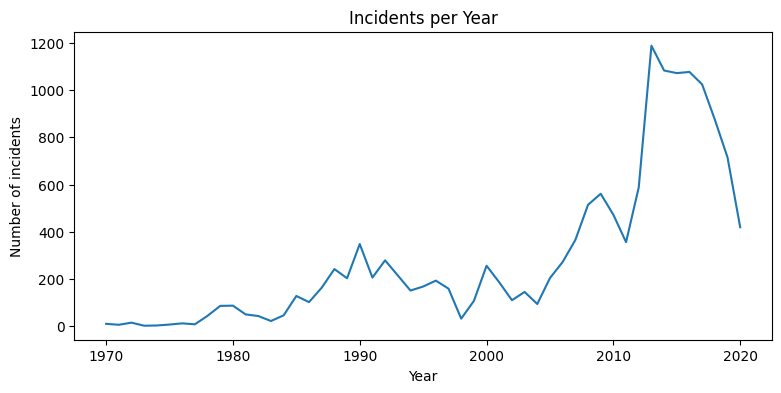

In [29]:
# --- Plot: yearly incidents (only if yearly exists) ---
import matplotlib.pyplot as plt

if "yearly" in locals() and not yearly.empty:
    ax = yearly.plot(x="iyear", y="incidents", kind="line", figsize=(9,4), legend=False)
    ax.set_title("Incidents per Year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of incidents")
    plt.show()



**Events per Year**
The trend shows a steady increase in terrorist activity peaking in 2014, suggesting escalation in
conflicts during that period, followed by a gradual decline.



/tmp/ipython-input-1681923008.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("event_date").resample("M").size().reset_index(name="count")


,event_date,count
0,1970-01-31,3
1,1970-02-28,0
2,1970-03-31,2
3,1970-04-30,2
4,1970-05-31,0
5,1970-06-30,2
6,1970-07-31,0
7,1970-08-31,0
8,1970-09-30,0
9,1970-10-31,0


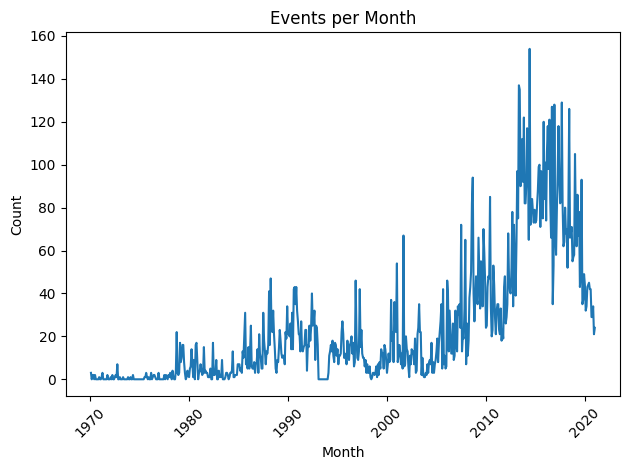

In [30]:
# 2) Events per MONTH (time series)
# -----------------------------
if df["event_date"].notna().any():
    monthly = df.set_index("event_date").resample("M").size().reset_index(name="count")
    display(monthly.head(24))

    plt.figure()
    plt.plot(monthly["event_date"], monthly["count"])
    plt.title("Events per Month")
    plt.xlabel("Month"); plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig(OUT_DIR / "events_per_month.png", dpi=150)
    plt.show()